In [1]:
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings
from Funciones import OLS_residual_diagnostic
warnings.filterwarnings('ignore')

<p style="text-align:center">
    <font size="8" style="color:darkred">
        <div style="text-align:center">
        Modelo Básico de Consumo Keynesiano
        </div>
    </font>

In [2]:
data = pd.read_csv('../data/Consumo Keynesiano.csv', parse_dates=['Periodos'], index_col='Periodos', infer_datetime_format=True)
data.head()

,C,Y,T
Periodos,,,
2010-03-31,9.927225e+06,14728836.41,303533
2010-06-30,1.002039e+07,14892561.66,266574
2010-09-30,1.005796e+07,15031765.74,274657
2010-12-31,1.020842e+07,15148037.52,290740
2011-03-31,1.020658e+07,15263122.53,327613


Los datos fueron extraidos del Banco de Información Económica (<a href="https://www.inegi.org.mx/app/indicadores/?tm=0#bodydataExplorer">BIE</a>) perteneciente al INEGI. Se tomaron las series desestacionalizadas a precios constantes del Consumo Privado y el Producto Interno Bruto. Del Sistema de Administración Tributaria se tomó la recaudación anual correspondiente al Impuesto Sobre la Renta, el Impuesto al Valor Añadido y el Impuesto Especial sobre Producción y Servicios y se sumaron para formar un dato trimestral.

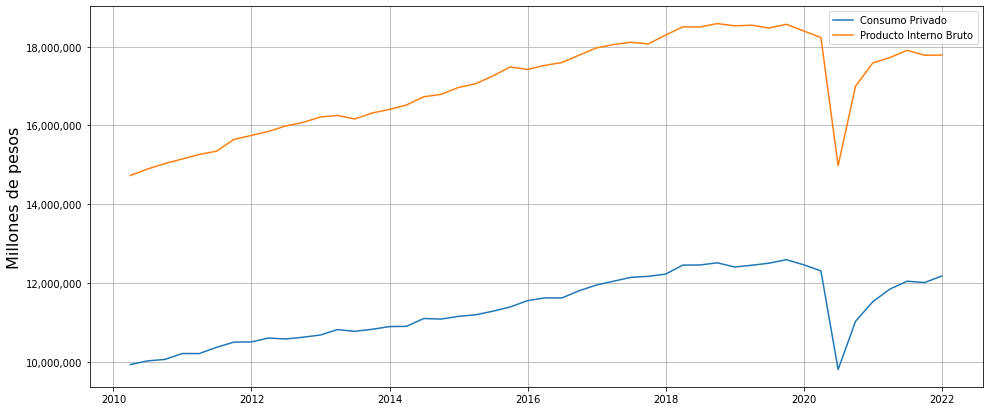

In [3]:
plt.figure(figsize=[16,7])

plt.plot(data['C'], label='Consumo Privado')
plt.plot(data['Y'], label='Producto Interno Bruto')

plt.ylabel('Millones de pesos', size=16)

plt.grid(True)
plt.legend()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]) # Elimina la escala de notación científica
plt.show()

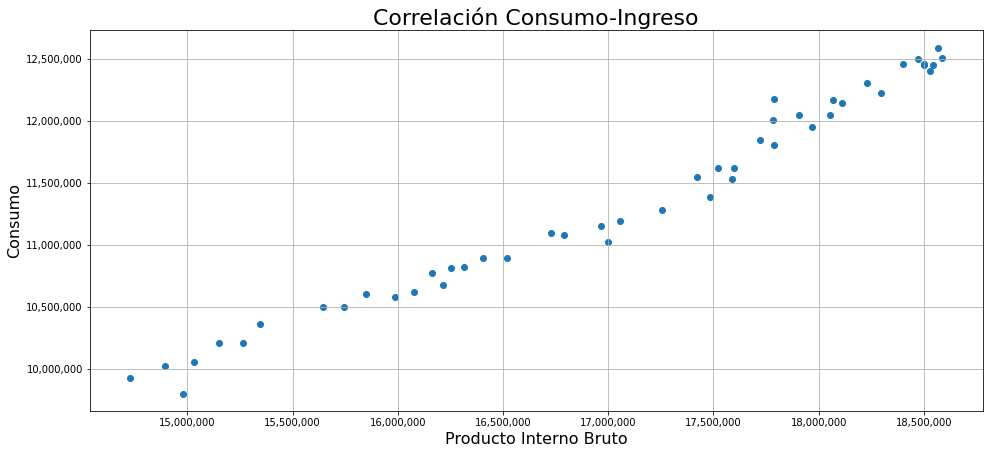

In [4]:
plt.figure(figsize=[16,7])

plt.scatter(data['Y'], data['C'])

plt.xlabel('Producto Interno Bruto', size=16)
plt.ylabel('Consumo', size=16)
plt.title('Correlación Consumo-Ingreso', size=22)

plt.grid(True)
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
plt.show()

La gráfica anterior muestra claramente la relación positiva que existe entre el consumo y el PIB. Por lo tanto, se esperaría que entre más aumente el PIB, existirá mayor consumo en la economía.

Para mostrar dicha relación, se tomará el modelo de consumo keynesiano básico expresado en la siguiente ecuación:<br><br>
\begin{align*}
    C_{t} &= c_{0} + c_{1}(Y_{t}-T)\\
    C_{t} &= c_{0} + c_{1}Yd_{t}
\end{align*}

Dónde:
    <li> $C_{t}$ es el consumo privado. </li>
    <li> $c_{0}$ es el consumo autónomo. </li>
    <li> $c_{1}$ es la propensión marginal a consumir. </li>
    <li> $Yd_{t}$ es el Ingreso disponible medido como el ingreso menos impuestos. </li>
    <li> $t$ es el tiempo representado en trimestres. </li>
<br>
Los parámetros $c_{0}$ y $c_{1}$ deben ser positivos. Como solo se desea abordar la parte técnca del lenguaje Python, no se explicará la teoría económica detrás de dicha ecuación, por lo tanto, se recomienda revisar la sección Consumo (pp. 52-53) del libro Macroeconomia - Teoria y Politica Con Aplicacion En America Latina de los autores Olivier Blanchard y Daniel Perez Enrri.

Se utilizó la serie del consumo privado para representar $C_{t}$ en el modelo, para el Ingreso ($Y_{t}$) se tomó el PIB como aproximación y de igual manera los impuestos.

In [5]:
data_niveles = pd.DataFrame(index=data.index)           # Crea un Dataframe para manipular mejor la información sin riesgo a que los datos originales sean modificados
data_niveles['C'] = np.log(data['C'])                   # Se aplica logaritmo a la serie para hacer más homogenea la escala de información y facilidad de interpretación a puntos porcentuales
data_niveles['Yd'] = data['Y'] - data['T']              # Cálculo del Ingreso disponible
data_niveles['Yd'] = np.log(data_niveles['Yd'])         # Aplica logaritmo al Ingreso disponible
Exog = sm.add_constant(data_niveles[['Yd']])            # Se extraen las variables exógenas y se les añade una constante

In [6]:
model = sm.OLS(data_niveles['C'], Exog.iloc[:,:2]).fit() # Primer Modelo
model.summary()                                          # Visualiza el modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      C   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     1196.
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           1.43e-34
Time:                        18:00:48   Log-Likelihood:                 136.27
No. Observations:                  48   AIC:                            -268.5
Df Residuals:                      46   BIC:                            -264.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9190      0.554     -5.268      0.000      -4.034      -1.804
Yd             1.1533      0.033     34.583      0.000       1.086       1.220
==============================================================================
Omnibus:                        0.763   Durbin-Watson:                   0.537
Prob(Omnibus):                  0.683   Jarque-Bera (JB):                0.853
Skew:                           0.257   Prob(JB):                        0.653
Kurtosis:                       2.597   Cond. No.                     4.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

El modelo anterior es exacto a la ecuación presentada en el libro. La constante y el ingreso resultan estadísticamente significativos al tener una probabilidad menor a 0.05 y determina que el valor de los coeficientes es diferente de cero.

Con respecto a la normalidad de los residuos, se puede ver que presentan una Kurtosis de 2.6, lo cual es muy cercano a la normalidad con valor de 3. Para asegurar dicho comportamiento, se aplicarán las pruebas de normalidad creadas a partir de los trabajos *"Tests for departure from normality"* y *"An omnibus test of normality for moderate and large sample size"* elaborados por D’Agostino y Pearson.

La hipótesis nula en ambas pruebas dice que los residuos tienen una distribución normal, por lo tanto, un valor-p mayor a 0.05 permite aceptar la hipótesis nula y concluir que los residuos presentan un comportamiento normal. Las pruebas aplicadas en este modelo permiten aceptar la hipótesis nula y se acepta la normalidad de los residuos.

In [7]:
OLS_residual_diagnostic(model)

,Valor Lagrange,Valor-P Lagrange,Valor F,Valor-P F
Acorr Breusch-Godfrey,29.644675,0.000504,6.639629,0.000014
Het Breusch-Pagan-Godfrey,0.00424,0.948079,0.004064,0.949445
Het Goldfeld-Quandt,-,-,5.036555,0.000177
Het White,1.305216,0.520686,0.628922,0.537787


Las pruebas anteriores permiten saber si existe homocedasticidad y no autocorrelación en los residuales. En el mismo sentido que la prueba Jarque-Bera u Omnibus, es decir, las hipótesis nulas establecen la no autocorrelación y homocedasticidad.

Para verificar la existencia de homocedasticidad se usan las pruebas Breusch-Godfrey, Breusch-Pagan-Godfrey y White. En dos de las tres pruebas se comprueba la homocedasticidad del modelo y resulta acorde a la distribución normal de los residuos.

En el caso de la autocorrelación, se revisa el valor Durbin-Watson de 0.537 que, por su distancia al valor 2, indica la existencia de autocorrelación en el modelo. Por lo anterior se realizó la prueba Breusch-Godfrey y se obtuvo un valor-p menor a 0.05, por lo tanto, se concluye la existencia de autocorrelación.

Como el modelo solo tiene una variable, se asume que no puede existir multicolinealidad, sin embargo, la salida de Python muestra que existen problemas numéricos en el modelo, uno de ellos podría ser multicolinealidad, pero como se mencionó, esto no tendría sentido.

In [8]:
data_niveles = pd.DataFrame(index=data.index)            # Crea un Dataframe para manipular mejor la información sin riesgo a que los datos originales sean modificados
data_niveles['C'] = np.log(data['C'])                    # Se aplica logaritmo a la serie para hacer más homogenea la escala de información y facilidad de interpretación a puntos porcentuales
data_niveles['Yd'] = data['Y'] - data['T']               # Cálculo del Ingreso disponible
data_niveles['Yd'] = np.log(data_niveles['Yd'])          # Aplica logaritmo al Ingreso disponible
data_niveles['Yd1'] = data_niveles['Yd'].shift()         # Crea un rezago a la serie del Ingreso
data_niveles['C1'] = data_niveles['C'].shift()           # Crea un rezago a la serie del Consumo
data_niveles = data_niveles.dropna()                     # Al obtener rezagos de una serie se pierde la misma cantidad de observaciones en la parte inicial o final de dicha serie
Exog = sm.add_constant(data_niveles[['Yd','Yd1','C1']])  # Se extraen las variables exógenas y se les añade una constante

Para corregir los problemas de autocorrelación del primer modelo, se agregaron a las variables explicativas dos rezagos, uno en el consumo y el otro en el ingreso.

Al realizar el segundo modelo se obtuvo que las nuevas variables exógenas son estadísticamente significativas individualmente y en su conjunto. Se mantiene la normalidad de los residuos de acuerdo a las pruebas Jarque-Bera y Omnibus.

In [9]:
model = sm.OLS(data_niveles['C'], Exog).fit()  # Segundo modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      C   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     921.3
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           5.08e-39
Time:                        18:00:59   Log-Likelihood:                 155.36
No. Observations:                  47   AIC:                            -302.7
Df Residuals:                      43   BIC:                            -295.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5640      0.467     -3.347      0.002      -2.506      -0.622
Yd             1.0837      0.042     25.983      0.000       1.000       1.168
Yd1           -0.7246      0.130     -5.581      0.000      -0.986      -0.463
C1             0.7290      0.103      7.058      0.000       0.521       0.937
==============================================================================
Omnibus:                        3.523   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                2.415
Skew:                           0.473   Prob(JB):                        0.299
Kurtosis:                       3.582   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Al aplicar la prueba Breusch_Godfrey, se obtiene un valor-p superior a 0.05 y el valor Durbin-Watson es de 1.8, siendo muy cercano al 2. Por lo anterior, se afirma que no existe autocorrelación en los residuos.

In [10]:
OLS_residual_diagnostic(model, Lags=1)

,Valor Lagrange,Valor-P Lagrange,Valor F,Valor-P F
Acorr Breusch-Godfrey,0.135307,0.712992,0.121262,0.729410
Het Breusch-Pagan-Godfrey,1.186076,0.756346,0.371076,0.774253
Het Goldfeld-Quandt,-,-,3.454784,0.004150
Het White,6.859084,0.651788,0.702487,0.702479


De igual manera, se procede a revisar la existencia de homocedasticidad con las pruebas aplicadas al modelo anterior. En ese sentido, dos de las tres pruebas determinan la existencia de homocedasticidad en el modelo.

Al momento de agregar rezagos, se agregaron más variables exógenas, entonces, sería correcto revisar la existencia de multicolinealidad mediante el VIF. Se observa un valor elevado entre las variables rezagadas, lo cual tiene sentido por la relación estrecha que tienen ambas variables en el gráfico de correlación.

In [13]:
VIF = pd.DataFrame()
VIF.index = Exog.columns[1:]
  
VIF['VIF'] = [variance_inflation_factor(Exog.values[1:], i+1) for i in range(len(Exog.columns[1:]))]
  
VIF

,VIF
Yd,3.152574
Yd1,35.084730
C1,30.667346


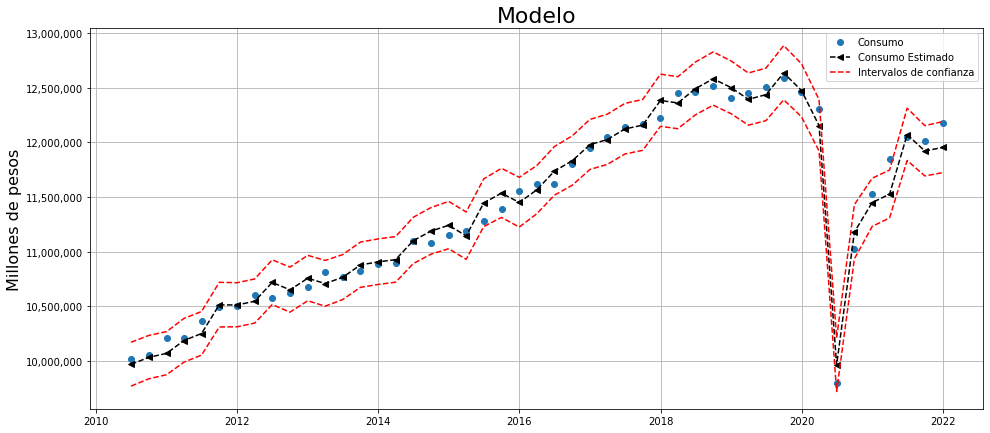

In [18]:
plt.figure(figsize=[16,7])

plt.plot(np.exp(data_niveles.C), 'o', label='Consumo')
plt.plot(np.exp(model.fittedvalues), color='black', linestyle='dashed', marker='<', label='Consumo Estimado')
plt.plot(np.exp(model.get_prediction().summary_frame()['obs_ci_lower']), "r--", label='Intervalos de confianza')
plt.plot(np.exp(model.get_prediction().summary_frame()['obs_ci_upper']), "r--")

plt.legend()
plt.grid(True)
plt.title('Modelo', size=22)
plt.ylabel('Millones de pesos', size=16)
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])

plt.show()

La gráfica muestra los datos del consumo y el consumo estimado con el modelo. Es observable un ajuste cercano entre el modelo y los valores reales, sin embargo, después del 2020 se observa el desajuste que provocó la pandemia en los periodos posteriores por la fuerte incertidumbre que ha existido en los últimos dos años, por lo cual, es normal que el modelo ya no se ajuste a la realidad y por esa razón el consumo en el periodo de la pandemia sale de los intervalos de confianza.

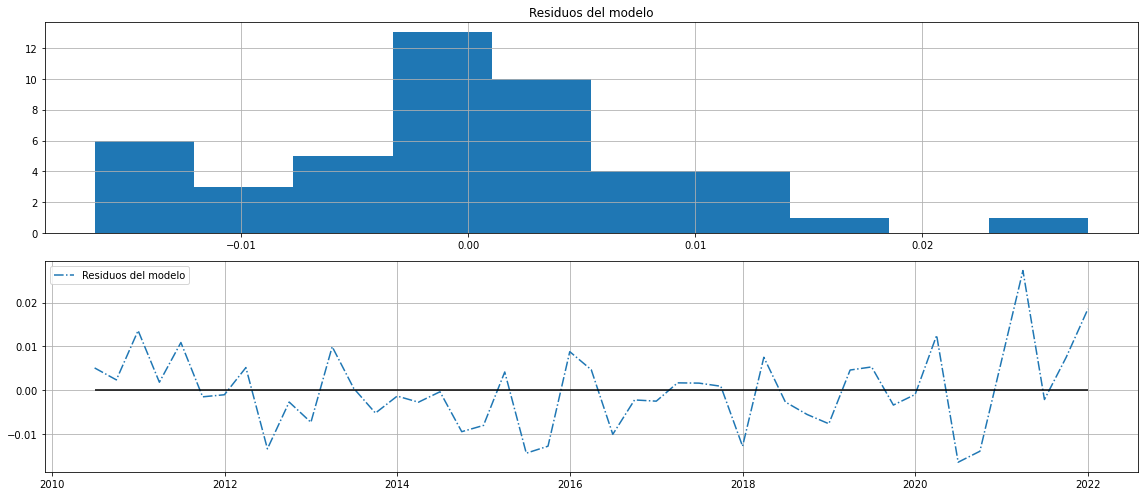

In [19]:
fig, axes = plt.subplots(2, figsize=(16, 7))

ax = axes[0]
ax.hist(model.resid)
ax.set(title='Residuos del modelo')
ax.grid(True)


ax = axes[1]
ax.plot(model.resid, label='Residuos del modelo', linestyle='-.')
ax.hlines(y=0, xmin=Exog.index[0], xmax=Exog.index[-1], color='black')
ax.grid(True)
ax.legend()

fig.tight_layout()

Al estimar el modelo, se modificó la estructura de la ecuación antes presentada, se le añadieron dos rezagos que antes no se encontraban representados, entonces, la nueva ecuación del modelo es la siguiente:
\begin{equation*}
        C_{t} = c_{0} + c_{1}Yd_{t}+c_{2}Yd_{t-1}+c_{3}C_{t-1}
\end{equation*}
Y los multiplicadores están dados por los coeficientes del modelo de la siguiente manera:
\begin{equation*}
        C_{t}=-1.5639 + 1.0837 Yd_{t}-0.7246Yd_{t-1}+0.7289C_{t-1}
\end{equation*}

Se debe considerar el incumplimiento de la restricción referente al consumo autónomo con signo positivo. En este punto se tienen dos posibilidades, se pueden realizar otros modelos que sean validados por la teoría económica o se justifica el resultado.

Por último, la existencia de rezagos en el modelo hace que su naturaleza ya no sea estática, es decir, el modelo se vuelve dinámico y se deben considerar los tiempos de ajuste. Lo anterior pertenece a las series temporales y no compete a la intención de este código. En ambos casos se puede revisar la teoría del consumo e ingreso permanente para una mejor comprensión económica.

<p style="text-align:center">
    <font face="times new roman" size="6" style="color:darkred">
        <div style="text-align:center">
        Anexos
        </div>
    </font>

<p style="text-align:center">
    <font face="times new roman" size="5" style="color:darkred">
        <div style="text-align:center">
        Primer modelo
        </div>
    </font>

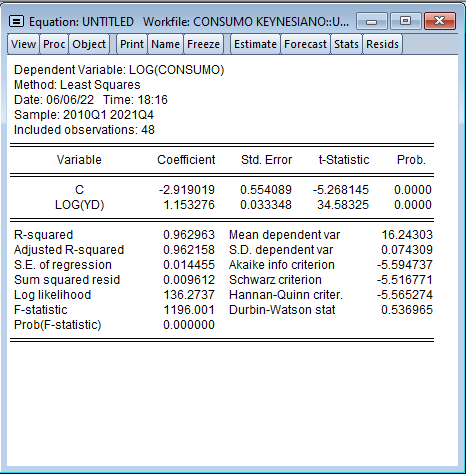 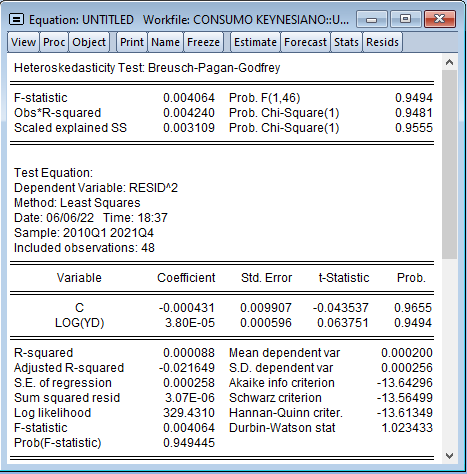 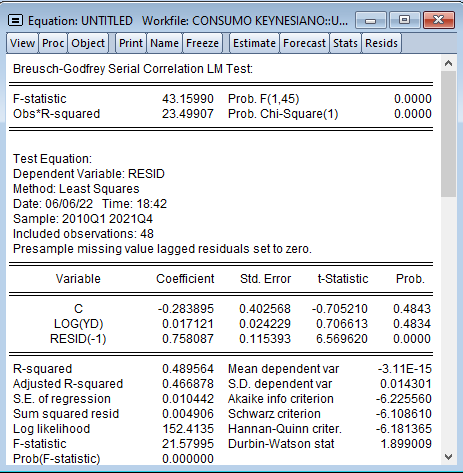

<p style="text-align:center">
    <font face="times new roman" size="5" style="color:darkred">
        <div style="text-align:center">
        Segundo modelo
        </div>
    </font>

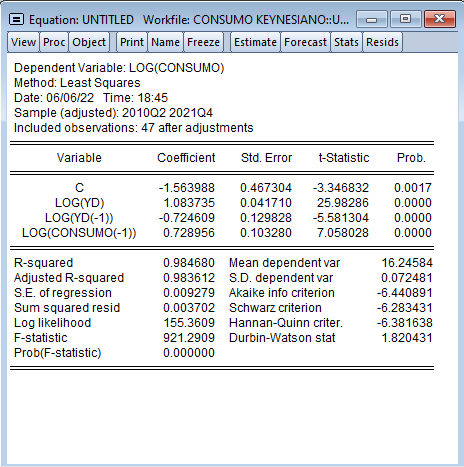 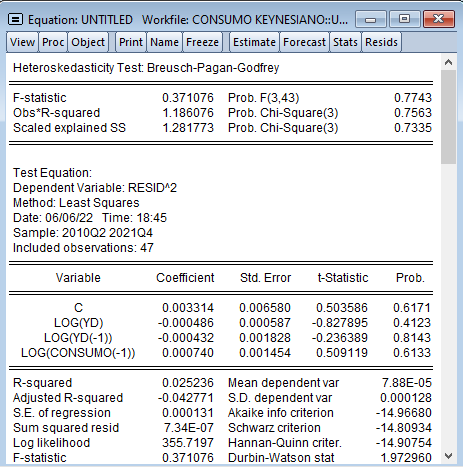 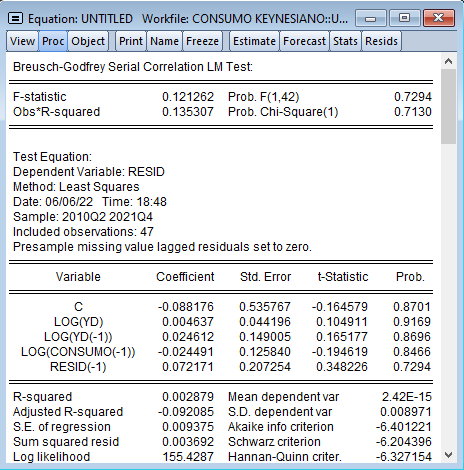